# 基于卷积神经网络 (CNN) 的图像分类任务
- 数据集：MNIST
- 深度学习框架：PyTorch

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

SEED = 2023
torch.manual_seed(SEED) # 设置随机种子，便于复现结果

BATCH_SIZE = 64
EPOCH_NUM = 20

## 1 数据准备

In [2]:
# 先将 PIL 图像的像素值由 [0, 255] 归一化为 [0,1]
# 再进行均值为 0.1307 、标准差为 0.3081 的标准化
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]
)

# 加载训练集数据，并划分出验证集
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
val_size = int(0.1 * len(train_set)) # 选取其中的 1/10 作为验证集
train_set, val_set = random_split(train_set, [len(train_set) - val_size, val_size], generator=torch.Generator().manual_seed(SEED))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 加载测试集数据
test_set = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print(f"train_size = {len(train_set)}")
print(f"val_size = {len(val_set)}")
print(f"test_size = {len(test_set)}")

train_size = 54000
val_size = 6000
test_size = 10000


## 2 模型构建

In [3]:
class MyCNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        # 特征提取层
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # 分类器层
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x) # 特征提取层的前向传播
        x = x.view(x.size(0), -1) # 将输入张量x进行形状变换，将其从多维的特征图展平为一维向量，以便输入到全连接层进行分类任务
        x = self.classifier(x) # 分类器层的前向传播
        return x

## 3 模型训练与评估

In [4]:
# 定义一个函数，用于在验证集或测试集上进行评估
def eval_model(net, epoch, acc_list, is_validation=True, is_print=True):
    net.eval()
    if is_validation == True:
        eval_loader = val_loader # 使用验证集数据加载器
    else:
        eval_loader = test_loader # 使用测试集数据加载器
    with torch.no_grad():
        correct = 0
        total = 0
        for imgs, labels in eval_loader: # 遍历验证数据集或测试数据集
            ouputs = net(imgs) # 前向传播计算输出
            _, predicted = torch.max(ouputs.data, 1) # 获取预测类别
            total += labels.size(0) # 累加样本数量
            correct += (predicted == labels).sum().item() # 累加正确分类的样本数量
        acc = correct / total
        acc_list.append(acc)
        if is_print == True:
            if is_validation == True:
                print(f"epoch {epoch} over, val_acc = {acc}")
            else:
                print(f"epoch {epoch} over, test_acc = {acc}")

In [5]:
net = MyCNN() # 创建自定义CNN模型的实例
criterion = nn.CrossEntropyLoss() # 定义交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.01) # 定义随机梯度下降（SGD）优化器，将模型参数传递给优化器进行优化

epoch_loss_list = [] # 记录每个epoch的损失值
val_acc_list = [] # 记录每个epoch在验证集上的准确率
test_acc_list = [] # 记录每个epoch在测试集上的准确率

epoch0_val_acc_list = [] # 记录第0个epoch在验证集上的准确率
epoch0_test_acc_list = [] # 记录第0个epoch在测试集上的准确率
batch_num_list = [] # 记录第0个epoch中被处理的批次数

for epoch in range(EPOCH_NUM): # 迭代训练多个epochs
    epoch_loss = 0 # 用于记录每个epoch的损失值
    for index, (imgs, labels) in enumerate(train_loader, 0): # 遍历训练数据集
        if epoch == 0 and index % 20 == 0:
            batch_num_list.append(index)
            eval_model(net=net, epoch=epoch, acc_list=epoch0_val_acc_list, is_validation=True, is_print=False) # 在验证集上进行测试
            eval_model(net=net, epoch=epoch, acc_list=epoch0_test_acc_list, is_validation=False, is_print=False) # 在测试集上进行测试
        optimizer.zero_grad() # 梯度清零，防止梯度累积
        ouputs = net(imgs) # 前向传播计算输出
        loss = criterion(ouputs, labels) # 计算损失值
        loss.backward() # 反向传播计算梯度
        optimizer.step() # 根据梯度更新模型参数
        epoch_loss += loss.item() # 累加损失值
    epoch_loss_list.append(epoch_loss)
    print(f"epoch {epoch} over, epoch_loss = {epoch_loss}") # 打印当前epoch的索引和损失值

    eval_model(net=net, epoch=epoch, acc_list=val_acc_list, is_validation=True, is_print=True) # 在验证集上进行测试

    eval_model(net=net, epoch=epoch, acc_list=test_acc_list, is_validation=False, is_print=True) # 在测试集上进行测试

epoch 0 over, epoch_loss = 960.9552184566855
epoch 0 over, val_acc = 0.924
epoch 0 over, test_acc = 0.9276
epoch 1 over, epoch_loss = 133.48430653475225
epoch 1 over, val_acc = 0.9698333333333333
epoch 1 over, test_acc = 0.9708
epoch 2 over, epoch_loss = 78.57007065042853
epoch 2 over, val_acc = 0.9698333333333333
epoch 2 over, test_acc = 0.9718
epoch 3 over, epoch_loss = 58.1847707121633
epoch 3 over, val_acc = 0.9788333333333333
epoch 3 over, test_acc = 0.9807
epoch 4 over, epoch_loss = 46.61667616199702
epoch 4 over, val_acc = 0.9795
epoch 4 over, test_acc = 0.9848
epoch 5 over, epoch_loss = 38.99297997774556
epoch 5 over, val_acc = 0.9848333333333333
epoch 5 over, test_acc = 0.9877
epoch 6 over, epoch_loss = 33.13113630504813
epoch 6 over, val_acc = 0.9851666666666666
epoch 6 over, test_acc = 0.9865
epoch 7 over, epoch_loss = 28.171972115931567
epoch 7 over, val_acc = 0.9846666666666667
epoch 7 over, test_acc = 0.9858
epoch 8 over, epoch_loss = 24.668063096294645
epoch 8 over, val_

## 4 性能分析

### 4.1 损失值关于epoch的变化曲线

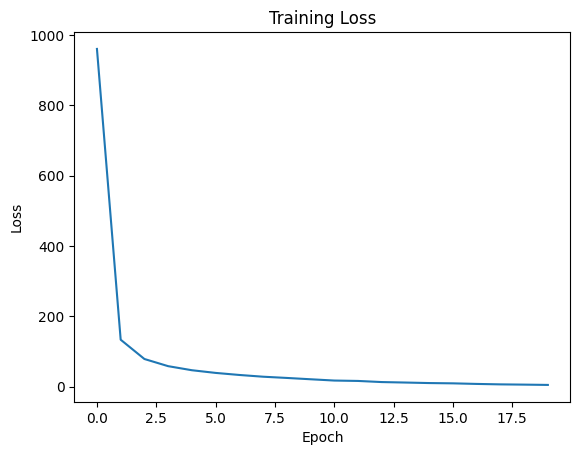

In [6]:
# 绘制损失变化曲线
plt.figure()
plt.plot(epoch_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### 4.2 验证集、测试集准确率关于epoch的变化曲线

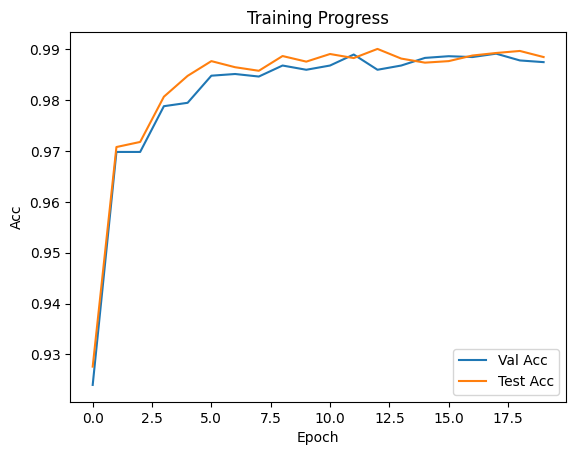

In [7]:
# 绘制准确率变化曲线
plt.figure()
plt.plot(range(len(val_acc_list)), val_acc_list, label='Val Acc')
plt.plot(range(len(test_acc_list)), test_acc_list, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Training Progress')
plt.legend()
plt.show()

### 4.3 第0个epoch的准确率关于batch数的变化曲线

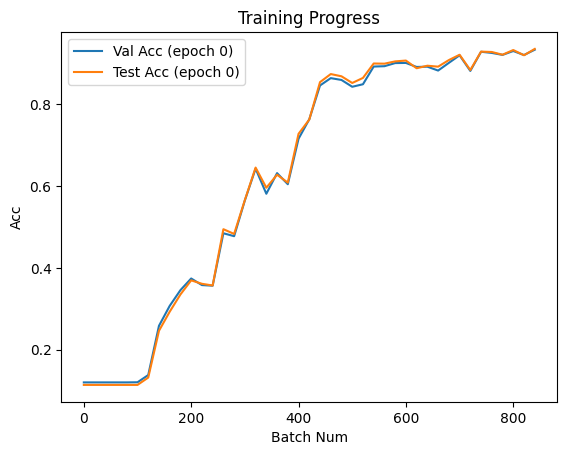

In [8]:
# 绘制准确率变化曲线
plt.figure()
plt.plot(batch_num_list, epoch0_val_acc_list, label='Val Acc (epoch 0)')
plt.plot(batch_num_list, epoch0_test_acc_list, label='Test Acc (epoch 0)')
plt.xlabel('Batch Num')
plt.ylabel('Acc')
plt.title('Training Progress')
plt.legend()
plt.show()